<a href="https://colab.research.google.com/github/avushek2305/Smai-Assignment-3/blob/main/Let's_Dive_into_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Let's Dive into CNNs
## Please read the following paragraph I copy-pasted from ChatGPT:
Welcome back to the exciting world of Convolutional Neural Networks (CNN), building on our previous question which focused on Multilayer Perceptrons (MLP)! As you already know, CNNs are a powerful tool for image and video processing applications. They are designed to recognize patterns and features in visual data, making them a popular choice in computer vision research. One of the reasons why CNNs are preferred over MLPs for image recognition tasks is their ability to handle high-dimensional input data, which preserves spatial information by applying convolutional filters to detect patterns and features at different locations in the input data.

One of the reasons why CNNs are preferred over MLPs for image recognition tasks is their ability to handle high-dimensional input data. MLPs are limited in their ability to process images because they require that the input data be flattened into a one-dimensional vector, which can result in a loss of important spatial information. In contrast, CNNs are designed to handle multi-dimensional data such as images, preserving spatial information by applying convolutional filters to detect patterns and features at different locations in the input data.

In this assignment, we will be playing with the CIFAR-10 dataset to explore different CNN models. We will start by training an auto-encoder for CIFAR images. This auto-encoder will allow us to compare different models, including a Multilayer Perceptron (MLP) model, a CNN-MLP mixed model, and finally a CNN-only model. By comparing the performance of these models, we can gain a deeper understanding of the importance of CNN layers in image processing tasks.

Once we've completed our auto-encoder experiments, we will use the encoder from the best-performing model to train a Siamese network. Siamese networks are a type of neural network that can recognize similarity between two images, making them a popular choice for tasks such as image retrieval and face recognition. By training a Siamese network using the CIFAR-10 dataset, we can gain a better understanding of how CNNs can be used in more complex image recognition tasks.

Overall, this assignment will allow us to explore the many different applications of CNNs in image processing tasks. We'll have the opportunity to experiment with different architectures, compare their performance, and gain valuable insights into how CNNs can be used to solve real-world problems.

🫵Pro-tip: Utilize learnings from previous question to better solve problems in this question.

💭Trivia: Yes, I am allowed use ChatGPT!

## Part 0: Initialization
### Step zero: Import Libraries

In [2]:
# code here
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import torch.nn as nn

In [3]:
# code here
import torch.optim as optim
import time

from prettytable import PrettyTable
 

### Step one: Using a PyTorch Dataset
Load CIFAR-10 dataset from `torchvision.datasets`. Keep batch_size >= 16.

In [11]:
# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    
])

# Load CIFAR-10 train and test datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [12]:

# Create data loaders for train and test datasets
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

torch.Size([32, 3, 32, 32])
torch.Size([32])


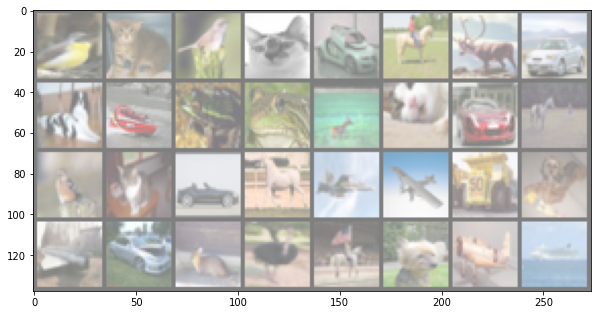

In [13]:
# let's have a look at the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.__next__()


print(images.shape)
print(labels.shape)

# show images
imshow(torchvision.utils.make_grid(images))

## Part 1: Auto-Encoder
### Step one: Define 3 Models for Auto-Encoder
1. MLP-only model
2. CNN-MLP combination model
3. CNN-only model

In all the models, encoder and decoder should be consisting of $3$ layers each, and the encoder should be giving a flattened representation of size $32$.

Please see that each layer of encoder should decrease or keep equal the output size as compared to input size. Similarly, each layer of decoder should increase or keep equal the output size as compared to input size. 

In [6]:


class MLP_Autoencoder(nn.Module):
    def __init__(self):
      super().__init__()
      self.encoder = nn.Sequential(
        
        nn.Linear(3072, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 32),
        nn.ReLU(),
        nn.Flatten()

      )
        
        # Decoder
      self.decoder = nn.Sequential(
            nn.Unflatten(-1, (1,1,32)),
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 3072),
            nn.ReLU(),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        y = self.encoder(x)
        x = self.decoder(y)
        x = x.view(x.size(0), 3, 32, 32)
        return y,x


In [7]:
class CNN_MLP_Autoencoder(nn.Module):
    def __init__(self, encoded_size=32):
        super(CNN_MLP_Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(64*4*4, 32),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64*4*4),
            nn.ReLU(),
            nn.Unflatten(-1, (64, 4, 4)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        y = self.encoder(x)
        x = self.decoder(y)
        return y,x


In [28]:
# class CNN_AutoEncoder(nn.Module):
#     def __init__(self):
#         super(CNN_AutoEncoder, self).__init__()
        
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3, 5, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(5, 7, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(7, 8, kernel_size=3, stride=3, padding=2),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Flatten()
            
#         )
        
#         self.decoder = nn.Sequential(
#             nn.Unflatten(-1, (8, 2, 2)),
#             nn.ConvTranspose2d(8, 7, kernel_size=3, stride=4, padding=0, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(7, 5, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(5, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.Tanh()
#         )

#     def forward(self, x):
#         y = self.encoder(x)
#         x = self.decoder(y)
#         return y,x

# [3,6,5,1,1,1,0,0,0,9,16,32,[32,1,1]]
class CNN_AutoEncoder(nn.Module):
    def __init__(self , k1 = 3 , k2 = 6 , k3=5 , s1 = 1 ,s2 = 1 ,s3 =1 , p1=0,p2=0,p3=0,d1 = 9,d2 = 16,d3 = 32 , final_repr = [32,1,1]):
        super(CNN_AutoEncoder,self).__init__()
        
        self.encL1 = nn.Conv2d(3, d1, kernel_size=k1, stride=s1,padding =p1)
        self.encL2 = nn.Conv2d(d1, d2, kernel_size=k2, stride=s2, padding=p2)
        self.encL3 = nn.Conv2d(d2, d3, kernel_size=k3, stride=s3, padding=p3)
        self.decL1 = nn.ConvTranspose2d(d3, d2, kernel_size=k3, stride=s3, padding=p3, output_padding=0)
        self.decL2 = nn.ConvTranspose2d(d2, d1, kernel_size=k2, stride=s2, padding=p2, output_padding=0)
        self.decL3 = nn.ConvTranspose2d(d1, 3, kernel_size=k1, stride=s1, padding=p1, output_padding=0)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2 , return_indices = True)
        self.maxunpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.unflatten = nn.Unflatten(-1, (d3, final_repr[1], final_repr[2]))

    
    def forward(self, x ):
        enc = self.encL1(x)
        enc = self.relu(enc)
        enc , indices1 = self.maxpool(enc)
        enc = self.encL2(enc)
        enc = self.relu(enc)
        enc , indices2 = self.maxpool(enc)
        enc = self.encL3(enc)
        enc = self.relu(enc)
        enc = self.flatten(enc)
        dec = self.unflatten(enc)
        dec = self.decL1(dec)
        dec = self.relu(dec)
        dec = self.maxunpool(dec,indices2)
        dec = self.decL2(dec)
        dec = self.relu(dec)
        dec = self.maxunpool(dec,indices1)
        dec = self.decL3(dec)
        dec = self.sigmoid(dec)
        return enc , dec



In [9]:
# sample code for a autoencoder:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        # Representation size: 3072
        # Number of Layers for encoder: 1
        # Number of Layers for decoder: 1
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1), # 3x32x32 -> 12x16x16
            nn.ReLU(),
            nn.Flatten(), # 12x16x16 -> 3072
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (12, 16, 16)), # 3072 -> 12x16x16
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1), # 12x16x16 -> 3x32x32
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


### Step two: Using MSELoss, train all the models and analyse results
Make sure you also discuss size, time-taken and any other differences you found. Plot MSELoss for each epoch for all models. Also, tabulate the final MSELosses of all models and plot it vis-a-vis:

1. Model Size
2. Model Parameters
3. Time Taken per epoch 

In [8]:
def MseLoss_models(model,trainloader,testloader,optimizer,criterion,model_name):
  t = PrettyTable(['Epoch', 'time'])

  # mlp_model = MLP_Autoencoder()
  # criterion = nn.MSELoss()
  # optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

  # Train model


  losses = []
  time_per_epoch = []
  for epoch in range(5):  # loop over the dataset multiple times
      print("Epoch 1 is starting....")
      start_time = time.time()
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          inputs, labels = data
          optimizer.zero_grad()
          feature,outputs = model(inputs)
          loss = criterion(inputs,outputs)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
        
      losses.append(running_loss / 200)
              
      end_time = time.time()
      time_per_epoch.append(end_time - start_time)


  # Plot loss per epoch
 

  # Calculate final loss on test set
  test_loss = 0.0
  with torch.no_grad():
      for data in testloader:
          inputs, _ = data
          # inputs = inputs.view(inputs.size(0), -1)
          _,outputs = model(inputs)
          loss = criterion(outputs, inputs)
          test_loss += loss.item()

  test_loss /= len(testloader.dataset)
  # print(model_name,'Final Test Loss:', test_loss)
  for i in range(5):
    t.add_row([i+1,time_per_epoch[i]])

  # print(t)

  return t,test_loss,losses


import matplotlib.pyplot as plt
def plot_losses(losses,model_name):
    plt.plot(losses)
    plt.title(model_name)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.show()

def calculate_final_loss(test_loss,model_name):
  print(model_name,'Final Test Loss:', test_loss)

def print_table(t):
  print(t)

Epoch 1 is starting....
Epoch 1 is starting....
Epoch 1 is starting....
Epoch 1 is starting....
Epoch 1 is starting....


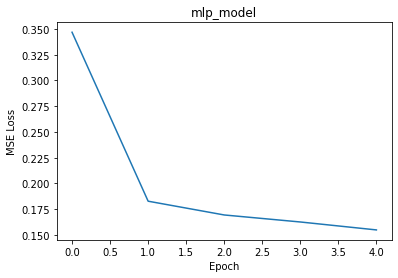

mlp_model Final Test Loss: 0.0006088344507850707
+-------+-------------------+
| Epoch |        time       |
+-------+-------------------+
|   1   | 63.14033627510071 |
|   2   | 75.54772210121155 |
|   3   |  74.7935950756073 |
|   4   | 74.54656481742859 |
|   5   | 73.79007482528687 |
+-------+-------------------+


In [26]:

# These 3 are the columns of the tables

# -------- mlp_model training ----------#
mlp_model = MLP_Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

t,test_loss,losses = MseLoss_models(mlp_model,trainloader,testloader,optimizer,criterion,'mlp_model')
plot_losses(losses,'mlp_model')
calculate_final_loss(test_loss,'mlp_model')
print_table(t)







In [ ]:
mlp_cnn_model = CNN_MLP_Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp_cnn_model.parameters(), lr=0.001)

Epoch 1 is starting....
Epoch 1 is starting....
Epoch 1 is starting....
Epoch 1 is starting....
Epoch 1 is starting....


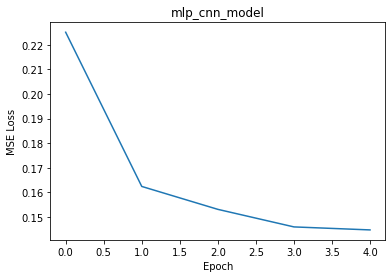

mlp_cnn_model Final Test Loss: 0.0005774132832884789
+-------+-------------------+
| Epoch |        time       |
+-------+-------------------+
|   1   | 71.89560151100159 |
|   2   | 70.99188184738159 |
|   3   | 71.80369400978088 |
|   4   | 71.84452605247498 |
|   5   | 71.20166158676147 |
+-------+-------------------+


In [ ]:
# -------- mlp_cnn_model training ----------#
mlp_cnn_model = CNN_MLP_Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp_cnn_model.parameters(), lr=0.001)

t,test_loss,losses = MseLoss_models(mlp_cnn_model,trainloader,testloader,optimizer,criterion,'mlp_cnn_model')
plot_losses(losses,'mlp_cnn_model')
calculate_final_loss(test_loss,'mlp_cnn_model')
print_table(t)

In [32]:
# -------- cnn_model training ----------#
cnn_model = CNN_AutoEncoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
summary(cnn_model,( 3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 30, 30]             252
              ReLU-2            [-1, 9, 30, 30]               0
         MaxPool2d-3  [[-1, 9, 15, 15], [-1, 9, 15, 15]]               0
            Conv2d-4           [-1, 16, 10, 10]           5,200
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6  [[-1, 16, 5, 5], [-1, 16, 5, 5]]               0
            Conv2d-7             [-1, 32, 1, 1]          12,832
              ReLU-8             [-1, 32, 1, 1]               0
           Flatten-9                   [-1, 32]               0
        Unflatten-10             [-1, 32, 1, 1]               0
  ConvTranspose2d-11             [-1, 16, 5, 5]          12,816
             ReLU-12             [-1, 16, 5, 5]               0
      MaxUnpool2d-13           [-1, 16, 10, 10]               0
  ConvTranspose2d-14   

Epoch 1 is starting....
Epoch 1 is starting....
Epoch 1 is starting....
Epoch 1 is starting....
Epoch 1 is starting....


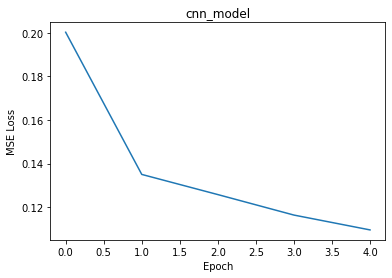

cnn_model Final Test Loss: 0.00043619141671806576
+-------+-------------------+
| Epoch |        time       |
+-------+-------------------+
|   1   | 74.20551419258118 |
|   2   | 70.27859592437744 |
|   3   | 72.80247664451599 |
|   4   | 70.19625329971313 |
|   5   | 71.84696078300476 |
+-------+-------------------+


In [33]:

# -------- cnn_model training ----------#
cnn_model = CNN_AutoEncoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

t,test_loss,losses = MseLoss_models(cnn_model,trainloader,testloader,optimizer,criterion,'cnn_model')
plot_losses(losses,'cnn_model')
calculate_final_loss(test_loss,'cnn_model')
print_table(t)

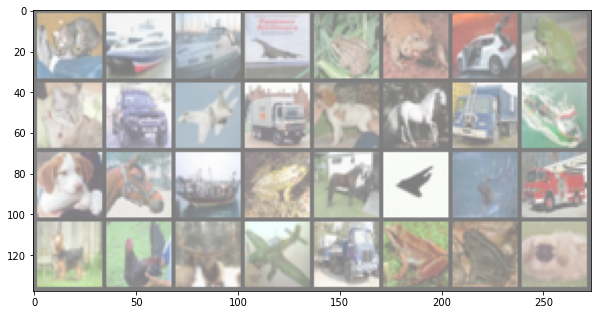

Reconstructed image


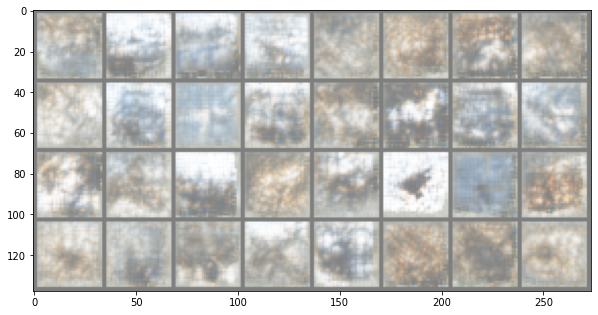

In [34]:
dataiter = iter(testloader)
images, labels = dataiter.__next__()
imshow(torchvision.utils.make_grid(images))
images = images.clone().detach().requires_grad_(True)

print("Reconstructed image")
decoded_imgs = cnn_model(images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs.data))

GroundTruth:  [tensor(3)] [tensor(8)] [tensor(8)] [tensor(0)] [tensor(6)]


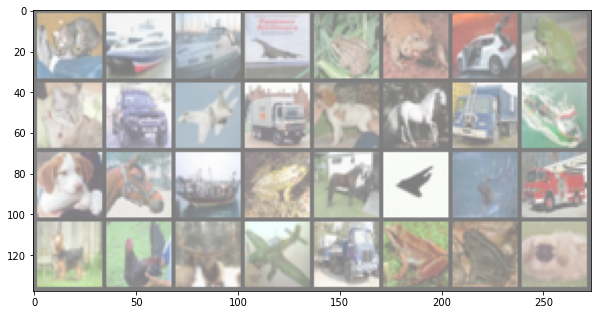

Reconstructed image


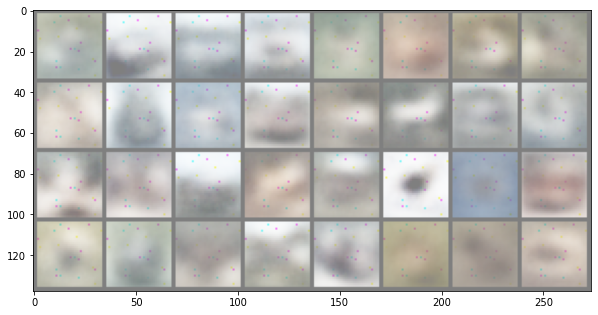

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.__next__()
print('GroundTruth: ', ' '.join('%5s' % [labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images))
images = images.clone().detach().requires_grad_(True)

print("Reconstructed image")
decoded_imgs = mlp_model(images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs.data))

GroundTruth:  [tensor(3)] [tensor(8)] [tensor(8)] [tensor(0)] [tensor(6)]


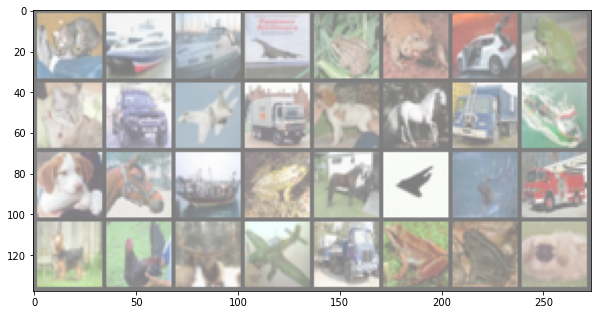

Reconstructed image


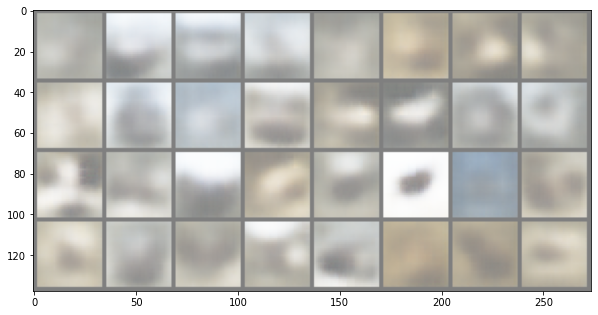

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.__next__()
print('GroundTruth: ', ' '.join('%5s' % [labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images))
images = images.clone().detach().requires_grad_(True)

print("Reconstructed image")
decoded_imgs = mlp_cnn_model(images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs.data))

In [ ]:
nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

In [22]:
# analysis, plots and tabulations here




print("--------------'mlp_model' -------------")
summary(mlp_model, (3072,))
print("--------------'mlp_cnn_model' -------------")
summary(mlp_cnn_model,( 3, 32, 32))
print("--------------'cnn_model' -------------")
summary(cnn_model,( 3, 32, 32))

--------------'mlp_model' -------------


NameError: ignored

In [ ]:
nn.Conv2d(3, 5, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(5, 7, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(7, 8, kernel_size=7, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.flatten()

### Step three: Let's play with Representation Sizes
Spoilers: You must have found CNN to be more effective.

Have you ever wondered how varying the size of a CNN auto-encoder's representation can affect its performance? If so, here's a challenge for you: Implement a CNN auto-encoder with different representation sizes and observe the impact on the reconstruction quality.

Play with the following representation sizes:
1. 10
2. 32
3. 100
4. 1000

When working with different representation sizes in a CNN auto-encoder, we may reach a point of diminishing returns where increasing the representation size does not lead to significant improvements in reconstruction quality. This can be due to factors such as increased model complexity and longer training times. Discuss where you feel we might reach this point of diminishing returns when working with CIFAR-10 dataset and varying representation sizes.

Do analysis as suggested earlier.

In [11]:
# code and analysis here

class CNN_WITH_REPRESENTATION_Autoencoder(nn.Module):
    def __init__(self, REPRESENTATION=10):
        super(CNN_WITH_REPRESENTATION_Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(64*4*4, REPRESENTATION),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(REPRESENTATION, 64*4*4),
            nn.ReLU(),
            nn.Unflatten(-1, (64, 4, 4)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        y = self.encoder(x)
        x = self.decoder(y)
        return y,x

----------------CNN_WITH_REPRESENTATION_Autoencoder 10----------------
Epoch 1 is starting....
Epoch 1 is starting....
Epoch 1 is starting....
Epoch 1 is starting....
Epoch 1 is starting....


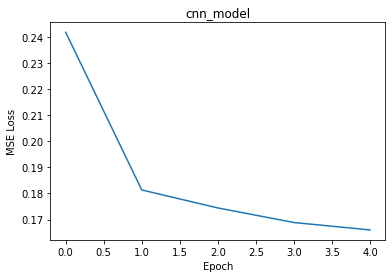

cnn_model Final Test Loss: 0.0006567017765715718
+-------+--------------------+
| Epoch |        time        |
+-------+--------------------+
|   1   | 53.51238417625427  |
|   2   | 51.25271725654602  |
|   3   | 50.43331694602966  |
|   4   | 50.79335808753967  |
|   5   | 50.968639850616455 |
+-------+--------------------+
----------------CNN_WITH_REPRESENTATION_Autoencoder 32----------------
Epoch 1 is starting....
Epoch 1 is starting....
Epoch 1 is starting....
Epoch 1 is starting....
Epoch 1 is starting....


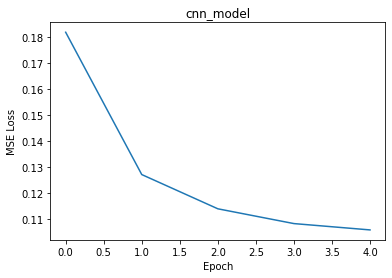

cnn_model Final Test Loss: 0.00042239533914253117
+-------+-------------------+
| Epoch |        time       |
+-------+-------------------+
|   1   |  74.2322244644165 |
|   2   | 72.92905735969543 |
|   3   | 72.99285531044006 |
|   4   |  73.3501546382904 |
|   5   |  74.5934488773346 |
+-------+-------------------+
----------------CNN_WITH_REPRESENTATION_Autoencoder 100----------------
Epoch 1 is starting....
Epoch 1 is starting....
Epoch 1 is starting....
Epoch 1 is starting....
Epoch 1 is starting....


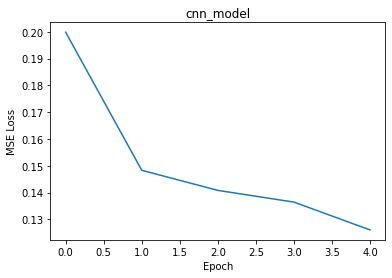

cnn_model Final Test Loss: 0.0004939045947045088
+-------+-------------------+
| Epoch |        time       |
+-------+-------------------+
|   1   |  74.0356502532959 |
|   2   | 73.74199414253235 |
|   3   | 72.38565731048584 |
|   4   | 74.58000040054321 |
|   5   | 72.21943068504333 |
+-------+-------------------+
----------------CNN_WITH_REPRESENTATION_Autoencoder 1000----------------
Epoch 1 is starting....
Epoch 1 is starting....
Epoch 1 is starting....
Epoch 1 is starting....
Epoch 1 is starting....


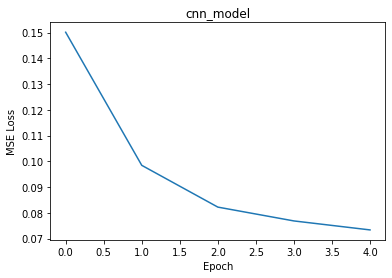

cnn_model Final Test Loss: 0.00028574361437931655
+-------+--------------------+
| Epoch |        time        |
+-------+--------------------+
|   1   | 59.45929145812988  |
|   2   | 66.00792574882507  |
|   3   | 59.581289291381836 |
|   4   | 61.047900915145874 |
|   5   | 59.04060912132263  |
+-------+--------------------+


In [40]:
rep = [10,32,100,1000]
rep_model = []
represet_sz = [10 , 32 , 100 ,1000]
parms10 = [3,6,5,1,1,1,0,0,0,5,8,10,[10,1,1]]
parms32 = [3,6,5,1,1,1,0,0,0,9,16,32,[32,1,1]]
parms100 = [5,7,3,1,1,1,0,0,0,6,12,25,[25,2,2]]
parms1000 = [3,2,3,1,1,1,0,0,0,10,20,40,[40,5,5]]
parms = [parms10 , parms32 , parms100 , parms1000]
for i in range(4):
  print('----------------CNN_WITH_REPRESENTATION_Autoencoder '+str(rep[i])+"----------------")
  model = CNN_AutoEncoder(parms[i][0],parms[i][1],parms[i][2],parms[i][3],parms[i][4],parms[i][5],parms[i][6],parms[i][7],parms[i][8],parms[i][9],parms[i][10],parms[i][11],parms[i][12])
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  t,test_loss,losses = MseLoss_models(model,trainloader,testloader,optimizer,criterion,'CNN_AutoEncoder'+str(rep[i]))
  # dataiter = iter(testloader)
  # images, labels = dataiter.__next__()
  # imshow(torchvision.utils.make_grid(images))
  # images = images.clone().detach().requires_grad_(True)

  # print("Reconstructed image")
  # decoded_imgs = model(images)[1]
  # imshow(torchvision.utils.make_grid(decoded_imgs.data))  
  plot_losses(losses,'cnn_model')
  calculate_final_loss(test_loss,'cnn_model')
  print_table(t)
  rep_model.append(model)




Reconstructed image


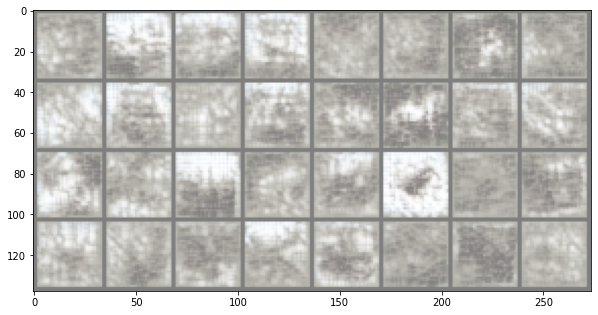

Reconstructed image


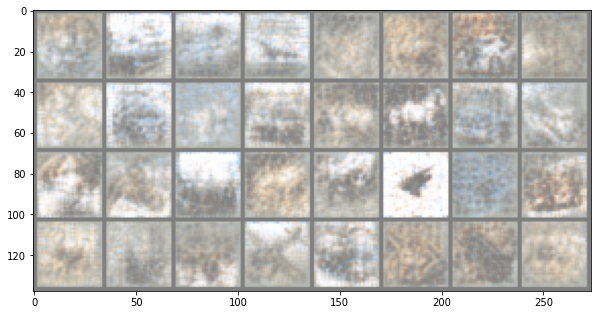

Reconstructed image


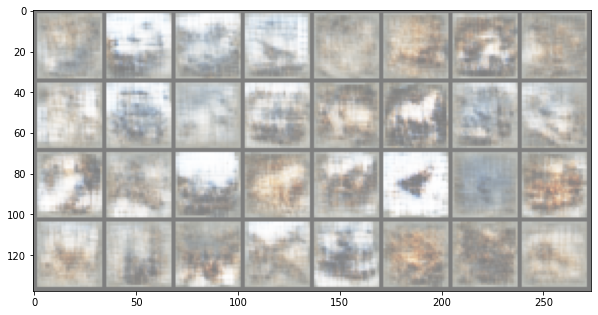

Reconstructed image


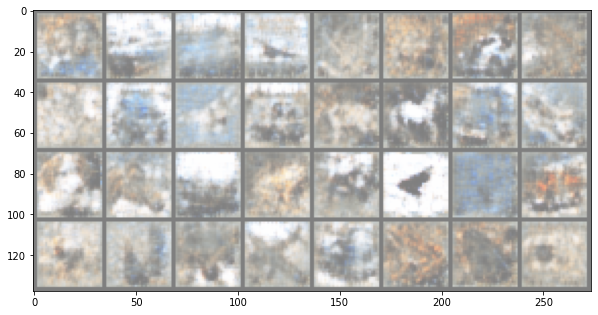

In [45]:
for model in rep_model:
  dataiter = iter(testloader)
  images, labels = dataiter.__next__()
  # imshow(torchvision.utils.make_grid(images))
  images = images.clone().detach().requires_grad_(True)

  print("Reconstructed image")
  decoded_imgs = model(images)[1]
  imshow(torchvision.utils.make_grid(decoded_imgs.data))

### Step four: What about the number of layers?

Experimenting with different numbers of layers in the encoder and decoder of a CNN auto-encoder can have a significant impact on its performance with CIFAR-10 dataset. For our next challenge, let's explore how the number of layers can affect the quality of the reconstructed images. Would a deeper or shallower network be more effective for this task?

Play with the following numbers of layers for encoder and decoder each:
1. 1
2. 3
3. 5
4. 10

When experimenting with different numbers of layers in the encoder and decoder of a CNN auto-encoder, we may reach a point of diminishing returns where adding more layers does not result in significant improvements in reconstruction quality. Additionally, deeper networks may be prone to overfitting, especially when training data is limited. Discuss where you feel we reach it. 

Do analysis as suggested earlier.

In [63]:
# code and analysis here
class layer1(nn.Module):
    def __init__(self):
        super(layer1, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        # Representation size: 3072
        # Number of Layers for encoder: 1
        # Number of Layers for decoder: 1
        self.encoder,self.index = nn.Sequential(
            nn.Conv2d(3, 8, 8, stride=9, padding=2), # 3x32x32 -> 12x16x16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2,return_indices = True),
            nn.Flatten(), # 12x16x16 -> 3072
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (8,2,2)), # 3072 -> 12x16x16
            nn.MaxUnpool2d(2,2, self.index),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, 8, stride=9, padding=2, output_padding=1), # 12x16x16 -> 3x32x32
            # nn.ReLU(),
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

Epoch 1 is starting....
Epoch 1 is starting....
Epoch 1 is starting....
Epoch 1 is starting....
Epoch 1 is starting....


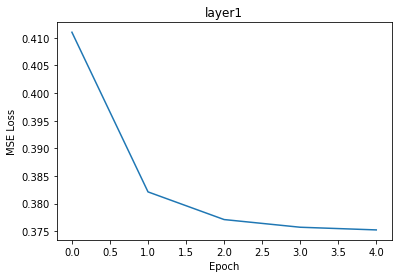

layer1 Final Test Loss: 0.0014834213871508836
+-------+--------------------+
| Epoch |        time        |
+-------+--------------------+
|   1   | 19.628603219985962 |
|   2   | 19.801479816436768 |
|   3   | 17.347170114517212 |
|   4   |  16.4056658744812  |
|   5   | 16.474770545959473 |
+-------+--------------------+


In [81]:
layer1 = layer1()
criterion = nn.MSELoss()
optimizer = optim.Adam(layer1.parameters(), lr=0.001)
summary(layer1,( 3, 32, 32))
t,test_loss,losses = MseLoss_models(layer1,trainloader,testloader,optimizer,criterion,'l1_cnn_model')
plot_losses(losses,'layer1')
calculate_final_loss(test_loss,'layer1')
print_table(t)

In [19]:
class layer5(nn.Module):
  def __init__(self):
    super(layer5, self).__init__()
    
    # encoder
    self.layer1 = nn.Sequential(
          nn.Conv2d(3, 4, 3, stride=1),
          nn.ReLU(),
        )
    
    self.layer2 = nn.Sequential(
        nn.Conv2d(4, 5, 3, stride=1), 
        nn.ReLU(),
        nn.MaxPool2d((2,2), stride=2, return_indices=True),
      )
  
    self.layer3 = nn.Sequential(
        nn.Conv2d(5, 6, 3, stride=1), 
        nn.ReLU(),
        nn.MaxPool2d((2,2), stride=2, return_indices=True),
      )
    
    self.layer4 = nn.Sequential(
        nn.Conv2d(6, 7, 3, stride=1),
        nn.ReLU(),
    )

    self.layer5 = nn.Sequential(
        nn.Conv2d(7, 8, 3, stride=1),
        nn.ReLU(),
        nn.Flatten(),
    )
    
    #decoder
    self.layer6 = nn.Sequential(
        nn.Unflatten(1,  (8, 2, 2)),
        nn.ConvTranspose2d(8, 7, 3, stride=1),
        nn.ReLU(),
      )
    
    self.layer7 = nn.Sequential(
        # nn.Unflatten(1,  (8, 2, 2)),
        nn.ConvTranspose2d(7, 6, 3, stride=1),
        nn.ReLU(),
      )
    
    self.unpool1 = nn.MaxUnpool2d(2, stride=2)

    self.layer8 = nn.Sequential(
        nn.ConvTranspose2d(6, 5, 3, stride=1),
        nn.ReLU(),
      )
    
    self.unpool2 = nn.MaxUnpool2d(2, stride=2)

    self.layer9 = nn.Sequential(
        nn.ConvTranspose2d(5, 4, 3, stride=1),
        nn.ReLU(),
      )
    self.layer10 = nn.Sequential(
        nn.ConvTranspose2d(4, 3, 3, stride=1),
        nn.Sigmoid(),
      )
    
  def forward(self, x):
    x = self.layer1(x)
    x, idx1 = self.layer2(x)
    x, idx2 = self.layer3(x)
    x = self.layer4(x)
    encoder = self.layer5(x) 

    x = self.layer6(encoder)
    x = self.layer7(x)
    x = self.unpool1(x, idx2)
    x = self.layer8(x)
    x = self.unpool2(x, idx1)
    x = self.layer9(x)
    decoder = self.layer10(x)
  
    return encoder, decoder

# cnnae5= layer5()

In [22]:
model = layer5()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
summary(model,( 3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 30, 30]             112
              ReLU-2            [-1, 4, 30, 30]               0
            Conv2d-3            [-1, 5, 28, 28]             185
              ReLU-4            [-1, 5, 28, 28]               0
         MaxPool2d-5  [[-1, 5, 14, 14], [-1, 5, 14, 14]]               0
            Conv2d-6            [-1, 6, 12, 12]             276
              ReLU-7            [-1, 6, 12, 12]               0
         MaxPool2d-8  [[-1, 6, 6, 6], [-1, 6, 6, 6]]               0
            Conv2d-9              [-1, 7, 4, 4]             385
             ReLU-10              [-1, 7, 4, 4]               0
           Conv2d-11              [-1, 8, 2, 2]             512
             ReLU-12              [-1, 8, 2, 2]               0
          Flatten-13                   [-1, 32]               0
        Unflatten-14     

Epoch 1 is starting....
Epoch 1 is starting....
Epoch 1 is starting....
Epoch 1 is starting....
Epoch 1 is starting....


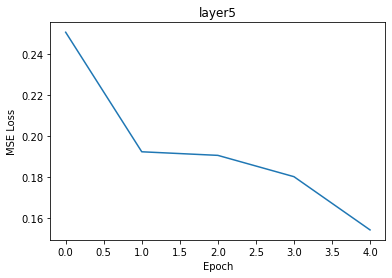

layer5 Final Test Loss: 0.0006017836108803749
+-------+--------------------+
| Epoch |        time        |
+-------+--------------------+
|   1   | 63.497061014175415 |
|   2   | 62.73141574859619  |
|   3   | 63.82234764099121  |
|   4   | 63.217350482940674 |
|   5   | 61.999319314956665 |
+-------+--------------------+


In [24]:
t,test_loss,losses = MseLoss_models(model,trainloader,testloader,optimizer,criterion,'layer5')
plot_losses(losses,'layer5')
calculate_final_loss(test_loss,'layer5')
print_table(t)

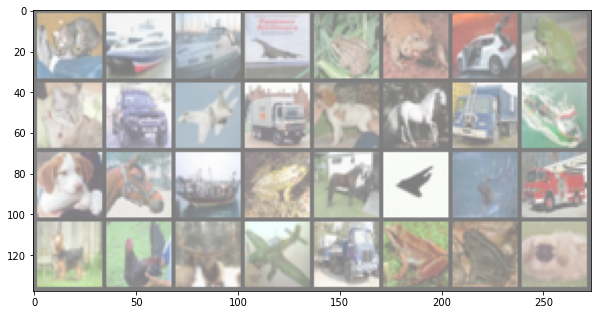

Reconstructed image


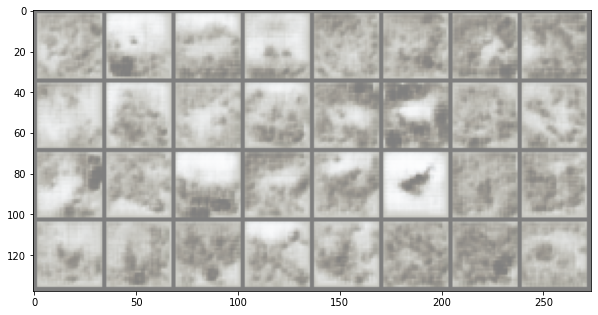

In [25]:
dataiter = iter(testloader)
images, labels = dataiter.__next__()
imshow(torchvision.utils.make_grid(images))
images = images.clone().detach().requires_grad_(True)

print("Reconstructed image")
decoded_imgs = model(images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs.data))

### Explaination time!
Please write a short-essay explaining what AutoEncoder does, how it is different from other data-representation methods like PCA, t-SNE and Variational AutoEncoders. Also tell what were your take-outs from this experiment.

In [ ]:
# explainations here

## Part 2: The return of kNN
Autoencoder representations can be useful for a wide range of machine learning tasks beyond just reconstructing input data. For example, the output of an encoder can be used as a feature representation for classification using k-Nearest Neighbors (kNN) or other classifiers. Similarly, the encoded representations can be used for unsupervised tasks like clustering, where the model groups similar images together based on their feature representation. This makes autoencoders a versatile tool for feature learning, with the potential to enhance the performance of a wide range of machine learning algorithms.

Since we have already trained auto-encoder on CIFAR-10, we will employ the encoder from the CNN model with representation size of $10$. Using a subset of CIFAR-10 train and test datasets, each with 10,000 and 1000 samples respectively, with an equal number of samples for each class, implement kNN classification using the encoder output as features. Share your findings and accuracy, F1 score and other relavant metrics on the test set. What insights can you draw from the results?

You are allowed to use sklearn or any other library for kNN and splitting dataset.

In [30]:
# Define the transformations to be applied to the images
# Select a subset of train and test datasets with equal number of samples per class
train_subset = []
test_subset = []
num_samples_per_class1 = 1000
num_samples_per_class2 = 100
for i in range(10):
    # Get indices of images with label i
    train_indices = np.where(np.array(train_dataset.targets) == i)[0]
    test_indices = np.where(np.array(test_dataset.targets) == i)[0]
    
    # Select num_samples_per_class random indices from the list
    selected_train_indices = np.random.choice(train_indices, num_samples_per_class1, replace=False)
    selected_test_indices = np.random.choice(test_indices, num_samples_per_class2, replace=False)
    
    # Add the selected images to the subset
    for index in selected_train_indices:
        train_subset.append(train_dataset[index])
    for index in selected_test_indices:
        test_subset.append(test_dataset[index])

# Create new train and test datasets from the subset
trainset_subset = torch.utils.data.Subset(torchvision.datasets.CIFAR10(root='./data', train=True, download=True), train_subset)
testset_subset = torch.utils.data.Subset(torchvision.datasets.CIFAR10(root='./data', train=False, download=True), test_subset)

Files already downloaded and verified
Files already downloaded and verified


In [31]:
print(len(trainset_subset))
print(len(testset_subset))

10000
1000


In [32]:
# code and analysis here. Remember to keep your analysis of high quality at all times.

model = CNN_AutoEncoder(3,6,5,1,1,1,0,0,0,5,8,10,[10,1,1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
t,test_loss,losses = MseLoss_models(model,trainloader,testloader,optimizer,criterion,'CNN_WITH_REPRESENTATION_Autoencoder')

Epoch 1 is starting....
Epoch 1 is starting....
Epoch 1 is starting....
Epoch 1 is starting....
Epoch 1 is starting....


In [42]:
# Encode the train set and the test set using the encoder
train_features = []
train_labels = []
# autoencoder = CNN_AutoEncoder()
with torch.no_grad():
  for images, labels in trainloader:
      images = images.clone().detach().requires_grad_(True)
      features = model(images)[0]
      train_features.append(features.detach().numpy())
      train_labels.append(labels.numpy())
  train_features = np.concatenate(train_features, axis=0)
  train_labels = np.concatenate(train_labels,axis = 0)

In [43]:
train_labels.shape

(50000,)

In [46]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

# Train the kNN classifier
k = 25
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(train_features, train_labels)

# Predict the labels of the test set using the kNN classifier
test_features = []
test_labels = []
with torch.no_grad():
  for images, labels in testloader:
      images = images.clone().detach().requires_grad_(True)
      features = model(images)[0]
      test_features.append(features.detach().numpy())
      test_labels.append(labels.numpy())
  test_features = np.concatenate(test_features, axis=0)
  test_labels = np.concatenate(test_labels, axis=0)
test_predictions = knn.predict(test_features)

# Compute the accuracy and F1 score of the kNN classifier on the test set
accuracy = accuracy_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions, average='macro')

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("F1 score: {:.2f}".format(f1))





Accuracy: 32.54%
F1 score: 0.32


## Part 3: Siamese Network (not part of assignment)
Siamese networks are useful for comparing and finding similarities between two inputs. The inputs from identical encoder sub-networks will be given as an input to a dense network (an MLP) and the prediction will be given as output of a Sigmoid function.

Employ the encoder from the best model to be used as the two-identical sub-networks of the Siamese Network. So, copy the weights from the best encoder to the two-identical sub-networks, set the learning rate of this encoder to be lower by a couple of order than that of the dense network.

Who knows, this might be part of next assignment during hectic times. (wink wink)
(Don't quote me on this though)

### Step one: Define a Siamese Network

In [ ]:
# sample.
class SiameseNetwork(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder1 = encoder
        self.encoder2 = encoder
        self.decoder = nn.Sequential(
            nn.Linear(2048,1024),
            # whatever
        )

    def forward(self, x1, x2):
        encoded1 = self.encoder1(x1)
        encoded2 = self.encoder2(x2)
        return (encoded1,encoded2)
        
    def differentiate(self, x1_embedding, x2_embedding):
        x = torch.cat([x1_embedding,x2_embedding],dim=1)
        return self.decoder(x)


### Step two: Define the following three losses:
1. TripletLoss
2. ContrastiveLoss
3. Regularized Cross Entropy Loss

In [ ]:
# TripletLoss defined as an example
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # Compute the distances between the anchor, positive, and negative examples
        distance_pos = F.pairwise_distance(anchor, positive, p=2)
        distance_neg = F.pairwise_distance(anchor, negative, p=2)
        # Compute the triplet loss using the margin
        loss_triplet = torch.mean(torch.clamp(distance_pos - distance_neg + self.margin, min=0.0))
        return loss_triplet

In [ ]:
# code here

### Train the Siamese network...
... and write a function that takes 2 inputs and outputs whether they belong to the same class or not. Plot and share the results of the function. The results should contain both successful results, i.e. classification as 'same' for inputs belonging to the same class and classification as 'not-same' for inputs belonging to different classes, as well as some unsuccessful results (that gives the wrong output than expected).
Provide an explanation of why the unsuccessful results might occur.

In [ ]:
# code and analysis here

### And again. What did we learn?
Discuss any and all learnings here. The discussions must be all-encompassing so that we know what did you learn. 

To re-iterate: "Please do not copy from your friend or copy-paste from the internet. We can see repetitions during evaluations."